In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import keras
from keras_unet.models import custom_unet

2023-02-01 14:00:43.740911: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
#DATAPATH = '/Users/jiehyun/Jenna/UMassBoston/Research/Nathan_Arnett_Calcification/'
DATAPATH = '/raid/mpsych/CACTAS/DATA/Nathan Arnett Calcification'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')


In [4]:
images = np.load(images_file)
labels = np.load(labels_file)

In [5]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [6]:
p = np.random.permutation(len(images))

In [7]:
images = images[p]
labels = labels[p]

In [8]:
images = images.astype(np.float64)
labels = labels.astype(np.float64)

In [9]:
for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

In [10]:
images.shape

(503, 512, 512, 1)

In [11]:
labels.shape

(503, 512, 512, 1)

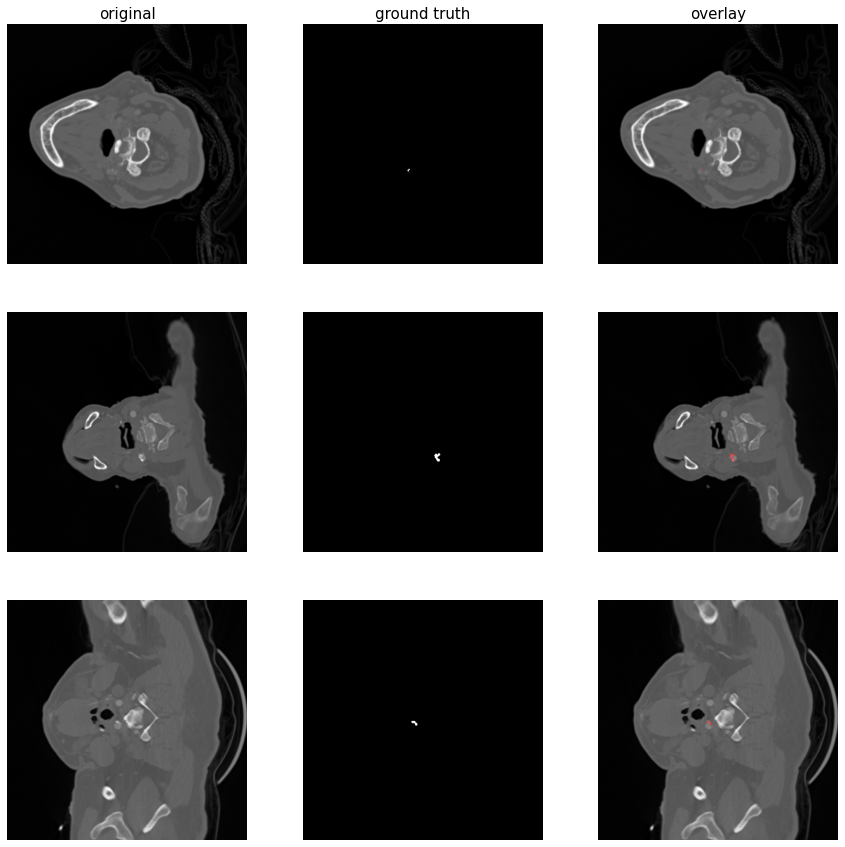

In [12]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=images, mask_imgs=labels, nm_img_to_plot=3, figsize=5)

In [13]:
X_train = images[0:300]
y_train = labels[0:300]
X_val = images[300:400]
y_val = labels[300:400]
X_test = images[400:]
y_test = labels[400:]

In [14]:
from keras_unet_collection import models, losses
import torch

model = models.swin_unet_2d((512, 512, 1), filter_num_begin=64,
                               n_labels=1, depth=4, stack_num_down=4, stack_num_up=4,
                               patch_size=(4, 4), num_heads=[4, 8, 16, 16],
                               window_size=[4, 4, 4, 4], num_mlp=512, 
                               output_activation='Sigmoid', shift_window=True, name='swin_unet')

#Softmax

2023-02-01 14:01:01.381256: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-01 14:01:01.551379: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-01 14:01:01.551421: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-01 14:01:01.551455: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-01 14:01:01.551472: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-01 14:01:01.552465: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [15]:
model.summary()

Model: "swin_unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
patch_extract (patch_extract)   (None, 16384, 16)    0           input_1[0][0]                    
__________________________________________________________________________________________________
patch_embedding (patch_embeddin (None, 16384, 64)    1049664     patch_extract[0][0]              
__________________________________________________________________________________________________
swin_transformer_block (SwinTra (None, 16384, 64)    83460       patch_embedding[0][0]            
____________________________________________________________________________________

In [16]:
from tensorflow.keras import optimizers
#from tensorflow.keras.optimizers import Adam
from keras_unet.metrics import iou, iou_thresholded, dice_coef
from keras_unet_collection import losses
#from keras_unet.losses import jaccard_distance

In [17]:
model.compile(loss='binary_crossentropy',
              #loss=jaccard_distance,
              optimizer=optimizers.Adam(lr=1e-3),
              #optimizer = 'Adam',
              metrics=['accuracy', dice_coef, iou, iou_thresholded])

/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [18]:
history = model.fit(X_train, 
                    y_train, 
                    batch_size=16, 
                    epochs=200,
                    validation_data=(X_val, y_val))

2023-02-01 14:01:16.248866: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-01 14:01:16.269176: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/200


2023-02-01 14:01:41.133493: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-01 14:01:42.040990: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-01 14:01:42.041355: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-01 14:01:42.171568: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-02-01 14:01:42.366129: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500
2023-02-01 14:01:42.881063: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-02-01 14:01:42.881095: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-02-01 14:01:42.88116

19/19 [==============================] - 46s 1s/step - loss: 0.1348 - accuracy: 0.9455 - dice_coef: 8.8782e-04 - iou: 7.9962e-04 - iou_thresholded: 9.1054e-04 - val_loss: 0.0063 - val_accuracy: 0.9998 - val_dice_coef: 0.0017 - val_iou: 0.0017 - val_iou_thresholded: 0.0018
Epoch 2/200
19/19 [==============================] - 14s 731ms/step - loss: 0.0050 - accuracy: 0.9998 - dice_coef: 9.5418e-04 - iou: 7.8607e-04 - iou_thresholded: 0.0012 - val_loss: 0.0039 - val_accuracy: 0.9998 - val_dice_coef: 0.0016 - val_iou: 0.0014 - val_iou_thresholded: 0.0018
Epoch 3/200
19/19 [==============================] - 14s 734ms/step - loss: 0.0039 - accuracy: 0.9997 - dice_coef: 0.0012 - iou: 9.5562e-04 - iou_thresholded: 0.0010 - val_loss: 0.0087 - val_accuracy: 0.9998 - val_dice_coef: 0.0018 - val_iou: 0.0018 - val_iou_thresholded: 0.0018
Epoch 4/200
19/19 [==============================] - 14s 743ms/step - loss: 0.0076 - accuracy: 0.9998 - dice_coef: 9.1495e-04 - iou: 9.0810e-04 - iou_thresholded: 

19/19 [==============================] - 14s 743ms/step - loss: 8.6944e-04 - accuracy: 0.9998 - dice_coef: 0.1832 - iou: 0.1021 - iou_thresholded: 0.1126 - val_loss: 0.0010 - val_accuracy: 0.9998 - val_dice_coef: 0.1309 - val_iou: 0.0714 - val_iou_thresholded: 0.0645
Epoch 31/200
19/19 [==============================] - 14s 741ms/step - loss: 7.6290e-04 - accuracy: 0.9998 - dice_coef: 0.2447 - iou: 0.1407 - iou_thresholded: 0.1706 - val_loss: 9.3247e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.1933 - val_iou: 0.1082 - val_iou_thresholded: 0.1381
Epoch 32/200
19/19 [==============================] - 14s 730ms/step - loss: 6.8569e-04 - accuracy: 0.9998 - dice_coef: 0.2963 - iou: 0.1754 - iou_thresholded: 0.2230 - val_loss: 8.6900e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.2174 - val_iou: 0.1238 - val_iou_thresholded: 0.1637
Epoch 33/200
19/19 [==============================] - 14s 741ms/step - loss: 6.2340e-04 - accuracy: 0.9998 - dice_coef: 0.3443 - iou: 0.2091 - iou_thresholded: 0.

Epoch 59/200
19/19 [==============================] - 14s 744ms/step - loss: 2.8258e-04 - accuracy: 0.9999 - dice_coef: 0.6204 - iou: 0.4504 - iou_thresholded: 0.5648 - val_loss: 6.4236e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.4158 - val_iou: 0.2676 - val_iou_thresholded: 0.2943
Epoch 60/200
19/19 [==============================] - 14s 736ms/step - loss: 2.7294e-04 - accuracy: 0.9999 - dice_coef: 0.6278 - iou: 0.4586 - iou_thresholded: 0.5682 - val_loss: 5.7837e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.4508 - val_iou: 0.2956 - val_iou_thresholded: 0.3491
Epoch 61/200
19/19 [==============================] - 14s 735ms/step - loss: 2.6835e-04 - accuracy: 0.9999 - dice_coef: 0.6326 - iou: 0.4636 - iou_thresholded: 0.5854 - val_loss: 6.0659e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.4415 - val_iou: 0.2886 - val_iou_thresholded: 0.3367
Epoch 62/200
19/19 [==============================] - 14s 740ms/step - loss: 2.6500e-04 - accuracy: 0.9999 - dice_coef: 0.6387 - iou: 0.4705 - io

Epoch 88/200
19/19 [==============================] - 14s 740ms/step - loss: 1.3325e-04 - accuracy: 0.9999 - dice_coef: 0.7990 - iou: 0.6658 - iou_thresholded: 0.7987 - val_loss: 6.4853e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.5190 - val_iou: 0.3576 - val_iou_thresholded: 0.3881
Epoch 89/200
19/19 [==============================] - 14s 749ms/step - loss: 1.2870e-04 - accuracy: 1.0000 - dice_coef: 0.8036 - iou: 0.6725 - iou_thresholded: 0.8037 - val_loss: 6.4672e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.5322 - val_iou: 0.3679 - val_iou_thresholded: 0.3977
Epoch 90/200
19/19 [==============================] - 14s 730ms/step - loss: 1.2530e-04 - accuracy: 1.0000 - dice_coef: 0.8069 - iou: 0.6772 - iou_thresholded: 0.8026 - val_loss: 6.6400e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.5237 - val_iou: 0.3606 - val_iou_thresholded: 0.3896
Epoch 91/200
19/19 [==============================] - 14s 739ms/step - loss: 1.3572e-04 - accuracy: 0.9999 - dice_coef: 0.8009 - iou: 0.6685 - io

Epoch 117/200
19/19 [==============================] - 14s 753ms/step - loss: 6.9205e-05 - accuracy: 1.0000 - dice_coef: 0.8884 - iou: 0.7994 - iou_thresholded: 0.9111 - val_loss: 7.6851e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.5509 - val_iou: 0.3882 - val_iou_thresholded: 0.4076
Epoch 118/200
19/19 [==============================] - 14s 737ms/step - loss: 6.7520e-05 - accuracy: 1.0000 - dice_coef: 0.8885 - iou: 0.7998 - iou_thresholded: 0.9129 - val_loss: 7.6890e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.5489 - val_iou: 0.3852 - val_iou_thresholded: 0.4040
Epoch 119/200
19/19 [==============================] - 14s 731ms/step - loss: 6.6738e-05 - accuracy: 1.0000 - dice_coef: 0.8918 - iou: 0.8050 - iou_thresholded: 0.9134 - val_loss: 7.6835e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.5550 - val_iou: 0.3916 - val_iou_thresholded: 0.4079
Epoch 120/200
19/19 [==============================] - 14s 745ms/step - loss: 6.4188e-05 - accuracy: 1.0000 - dice_coef: 0.8948 - iou: 0.8099 

Epoch 146/200
19/19 [==============================] - 14s 732ms/step - loss: 4.1567e-05 - accuracy: 1.0000 - dice_coef: 0.9304 - iou: 0.8700 - iou_thresholded: 0.9539 - val_loss: 9.1488e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.5545 - val_iou: 0.3926 - val_iou_thresholded: 0.4020
Epoch 147/200
19/19 [==============================] - 14s 744ms/step - loss: 4.1639e-05 - accuracy: 1.0000 - dice_coef: 0.9314 - iou: 0.8717 - iou_thresholded: 0.9541 - val_loss: 8.9213e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.5622 - val_iou: 0.4000 - val_iou_thresholded: 0.4137
Epoch 148/200
19/19 [==============================] - 14s 736ms/step - loss: 4.0840e-05 - accuracy: 1.0000 - dice_coef: 0.9317 - iou: 0.8723 - iou_thresholded: 0.9538 - val_loss: 9.0817e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.5650 - val_iou: 0.4017 - val_iou_thresholded: 0.4127
Epoch 149/200
19/19 [==============================] - 14s 744ms/step - loss: 4.0976e-05 - accuracy: 1.0000 - dice_coef: 0.9308 - iou: 0.8708 

Epoch 175/200
19/19 [==============================] - 14s 744ms/step - loss: 2.5855e-05 - accuracy: 1.0000 - dice_coef: 0.9509 - iou: 0.9066 - iou_thresholded: 0.9901 - val_loss: 9.1904e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.5606 - val_iou: 0.3991 - val_iou_thresholded: 0.4085
Epoch 176/200
19/19 [==============================] - 14s 748ms/step - loss: 2.4607e-05 - accuracy: 1.0000 - dice_coef: 0.9528 - iou: 0.9099 - iou_thresholded: 0.9915 - val_loss: 9.2665e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.5627 - val_iou: 0.4015 - val_iou_thresholded: 0.4122
Epoch 177/200
19/19 [==============================] - 14s 739ms/step - loss: 2.3255e-05 - accuracy: 1.0000 - dice_coef: 0.9556 - iou: 0.9150 - iou_thresholded: 0.9931 - val_loss: 9.3034e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.5635 - val_iou: 0.4023 - val_iou_thresholded: 0.4122
Epoch 178/200
19/19 [==============================] - 14s 737ms/step - loss: 2.2113e-05 - accuracy: 1.0000 - dice_coef: 0.9570 - iou: 0.9177 

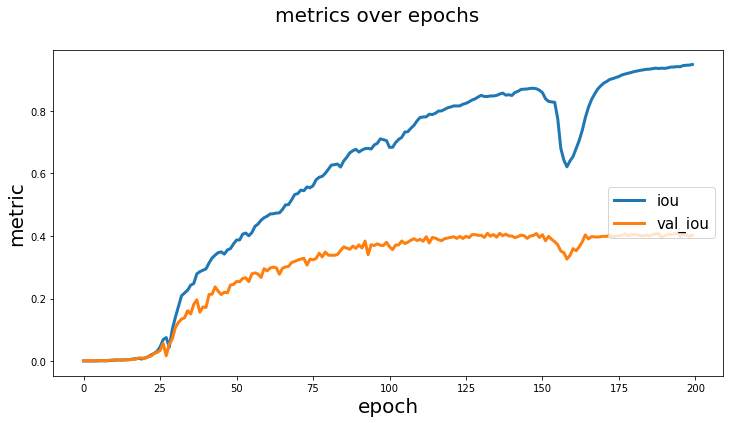

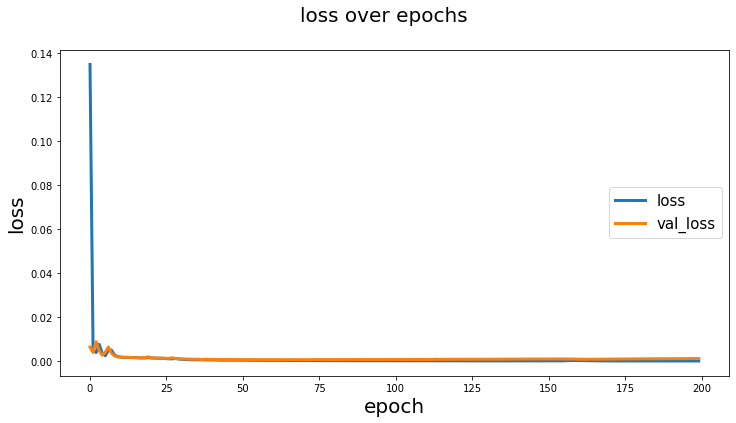

In [19]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [20]:
y_pred = model.predict(X_test)

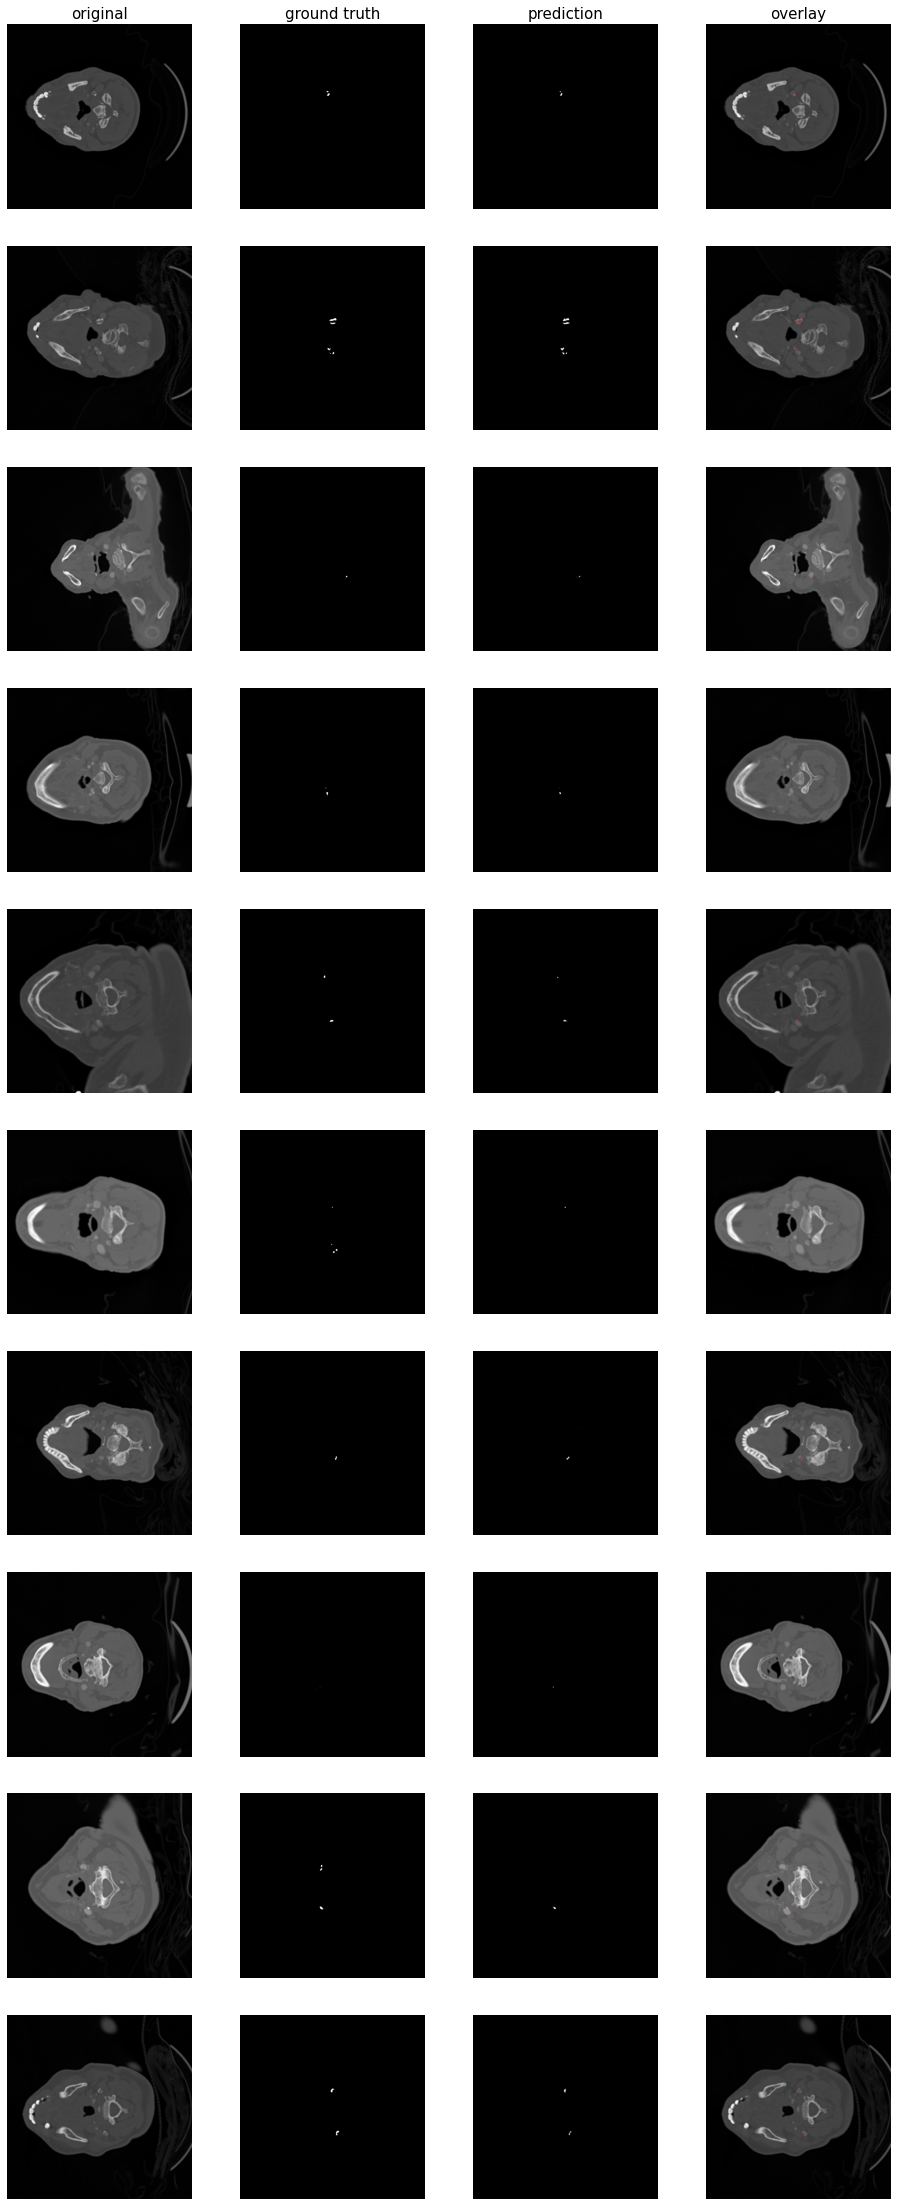

In [21]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=10)

In [23]:
loss, iou, iou_thresholded = model.evaluate(X_test, y_test)

4/4 [==============================] - 2s 357ms/step - loss: 0.0011 - accuracy: 0.9998 - dice_coef: 0.5951 - iou: 0.4239 - iou_thresholded: 0.4305


ValueError: too many values to unpack (expected 3)